 # Neural ODEs to learn multiple ODEs simulatnuously

 We have two encioders and two decoders, but only one processor

In [1]:
import jax

# import os
# jax.config.update("jax_platform_name", "cpu")
# os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=4'
print("Available devices:", jax.devices())

from jax import config
config.update("jax_debug_nans", True)

import jax.numpy as jnp
import numpy as np
import equinox as eqx

# import pickle
# import torch

from parajax.utils import *
from parajax.integrators import *

import optax
from functools import partial
import time

Available devices: [cuda(id=0)]


In [2]:
SEED = 27

## Dataset hps
window_size = 100

## Integrator hps
integrator = rk4_integrator
# integrator = dopri_integrator_diff    ## TODO tell Patrick that this can be unstable

## Optimiser hps
init_lr = 5e-4
decay_rate = 0.95

## Training hps
print_every = 100
nb_epochs = 4000
batch_size = 500

## Plotting hps 
plt_hor = 1000

In [3]:
sp = jnp.load('data/simple_pendulum.npz')
X1_raw = jnp.concatenate([sp['X'].T, sp['t'][:, None]], axis=-1)

ip = jnp.load('data/inverted_pendulum.npz')
X2_raw = jnp.concatenate([ip['X'].T, ip['t'][:, None]], axis=-1)

# X = jnp.concatenate([X1[:, :-1], X2], axis=-1)
# X

def split_into_windows(X_raw, window_size):
    X_windows = []
    for i in range(0, X_raw.shape[0]-window_size, 4):
        X_windows.append(X_raw[i:i+window_size])
    return jnp.array(X_windows)


X1 = split_into_windows(X1_raw, window_size)
X2 = split_into_windows(X2_raw, window_size)


def suffle(X,):
    key = get_new_key(SEED)
    return jax.random.permutation(key=key, axis=0, x=X)

X1 = suffle(X1)
X2 = suffle(X2)

print("Datasets sizes:", X1.shape, X2.shape)

Datasets sizes: (2476, 100, 3) (2476, 100, 5)


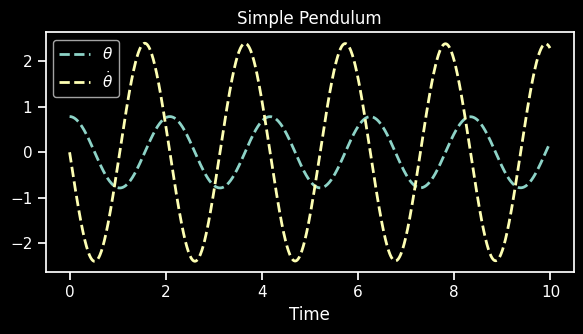

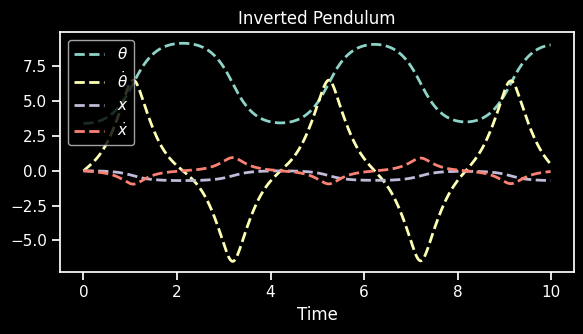

In [4]:
sp_to_plot = X1_raw[:plt_hor]
ax = sbplot(sp_to_plot[:, -1], sp_to_plot[:, 0], "--", x_label='Time', label=r'$\theta$', title='Simple Pendulum')
ax = sbplot(sp_to_plot[:, -1], sp_to_plot[:, 1], "--", x_label='Time', label=r'$\dot \theta$', ax=ax)

ip_to_plot = X2_raw[:plt_hor]
ax = sbplot(ip_to_plot[:, -1], ip_to_plot[:, 2], "--", x_label='Time', label=r'$\theta$', title='Inverted Pendulum')
ax = sbplot(ip_to_plot[:, -1], ip_to_plot[:, 3], "--", x_label='Time', label=r'$\dot \theta$', ax=ax)
ax = sbplot(ip_to_plot[:, -1], ip_to_plot[:, 0], "--", x_label='Time', label=r'$x$', ax=ax)
ax = sbplot(ip_to_plot[:, -1], ip_to_plot[:, 1], "--", x_label='Time', label=r'$\dot x$', ax=ax)

In [5]:
class Encoder(eqx.Module):
    layers: list

    def __init__(self, in_size=2, out_size=2, key=None):
        keys = get_new_key(key, num=2)
        self.layers = [eqx.nn.Linear(in_size, 100, key=keys[0]), jax.nn.tanh,
                        eqx.nn.Linear(100, out_size, key=keys[1]) ]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Processor(eqx.Module):
    layers: list

    def __init__(self, in_out_size=2, key=None):
        keys = get_new_key(key, num=3)
        self.layers = [eqx.nn.Linear(in_out_size+1, 100, key=keys[0]), jax.nn.tanh,
                        eqx.nn.Linear(100, 100, key=keys[1]), jax.nn.tanh,
                        eqx.nn.Linear(100, in_out_size, key=keys[2])]

    def __call__(self, x, t):
        y = jnp.concatenate([jnp.broadcast_to(t, (1,)), x], axis=0)
        for layer in self.layers:
            y = layer(y)
        return y


class Decoder(eqx.Module):
    layers: list

    def __init__(self, in_size=2, out_size=2, key=None):
        keys = get_new_key(key, num=2)
        self.layers = [eqx.nn.Linear(in_size, 100, key=keys[0]), jax.nn.tanh,
                        eqx.nn.Linear(100, out_size, key=keys[1]) ]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

keys = get_new_key(SEED, num=5)
latent_size = 2

d1 = X1.shape[-1] - 1
E1 = Encoder(in_size=d1, out_size=latent_size, key=keys[0])
D1 = Decoder(in_size=latent_size, out_size=d1, key=keys[1])

d2 = X2.shape[-1] - 1
E2 = Encoder(in_size=d2, out_size=latent_size, key=keys[2])
D2 = Decoder(in_size=latent_size, out_size=d2, key=keys[3])

P = Processor(in_out_size=latent_size*2, key=keys[4])

model = (E1, E2, P, D1, D2)
params, static = eqx.partition(model, eqx.is_array)

In [6]:
def l2_norm(X, X_hat):
    total_loss =  jnp.mean((X - X_hat)**2, axis=-1)
    return jnp.sum(total_loss) / (X.shape[0] * X.shape[1])

def loss_fn(params, static, batch):
    X1, X2 = batch
    model = eqx.combine(params, static)

    E1, E2, P, D1, D2 = model       ## TODO vmap the model directly

    E1_batched, E2_batched = jax.vmap(E1), jax.vmap(E2)
    latent1 = E1_batched(X1[:, 0, :-1])
    latent2 = E2_batched(X2[:, 0, :-1])

    latent = jnp.concatenate([latent1, latent2], axis=-1)       ## TODO only latent1 used
    # latent = latent1 + latent2
    t = X1[0, ..., -1]

    P_params, P_static = eqx.partition(P, eqx.is_array)
    integrator_batched = jax.vmap(integrator, in_axes=(None, None, 0, None, None, None, None, None, None, None))
    
    ## Check these params !!
    latent_final = integrator_batched(P_params, P_static, latent, t, 1.4e-8, 1.4e-8, jnp.inf, jnp.inf, 50, "checkpointed")

    # latent_dot = P(latent, t)     ## TODO apparently, it is tradition to let the dot go to ZERO

    D1_, D2_ = jax.vmap(D1), jax.vmap(D2)
    D1_batched, D2_batched = jax.vmap(D1_), jax.vmap(D2_)
    X1_hat = D1_batched(latent_final[..., :latent_size])
    X2_hat = D2_batched(latent_final[..., latent_size:])

    ## Norms of 2-dimensional and 4-dimensional vectors
    # total_loss = jnp.mean((X1[..., :-1] - X1_hat)**2, axis=-1) + jnp.mean((X2[..., :-1] - X2_hat)**2, axis=-1)
    # return jnp.sum(total_loss) / (X1.shape[0] * X1.shape[1])

    return l2_norm(X1[..., :-1], X1_hat) + l2_norm(X2[..., :-1], X2_hat)

@partial(jax.jit, static_argnums=(1))
def train_step(params, static, batch, opt_state):
    print('\nCompiling function "train_step" ...\n')

    loss, grads = jax.value_and_grad(loss_fn)(params, static, batch)

    # losses, grads = jax.vmap(jax.value_and_grad(loss_fn), in_axes=(None, None, 0))(params, static, batch)
    # loss = jnp.mean(losses)

    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

In [7]:
nb_examples = X1.shape[0]

sched = optax.exponential_decay(init_lr, nb_epochs*int(np.ceil(nb_examples//batch_size)), decay_rate)
opt = optax.adam(sched)
opt_state = opt.init(params)

start_time = time.time()

losses = []
for epoch in range(nb_epochs):

    nb_batches = 0
    loss_sum = 0.
    for i in range(0, nb_examples, batch_size):
        batch = (X1[i:i+batch_size], X2[i:i+batch_size])      ## TODO vmap to increase this batch size
    
        params, opt_state, loss = train_step(params, static, batch, opt_state)

        loss_sum += loss
        nb_batches += 1

    loss_epoch = loss_sum/nb_batches
    losses.append(loss_epoch)

    if epoch%print_every==0 or epoch<=3 or epoch==nb_epochs-1:
        print(f"Epoch: {epoch:-4d}      Loss: {loss_epoch:.5f}")


wall_time = time.time() - start_time
time_in_hmsecs = seconds_to_hours(wall_time)
print("\nTotal training time: %d hours %d mins %d secs" %time_in_hmsecs)

model = eqx.combine(params, static)


Compiling function "train_step" ...


Compiling function "train_step" ...

Epoch:    0      Loss: 16.81979
Epoch:    1      Loss: 15.89894
Epoch:    2      Loss: 15.10427
Epoch:    3      Loss: 14.34423
Epoch:  100      Loss: 1.89571
Epoch:  200      Loss: 1.42328
Epoch:  300      Loss: 1.28469
Epoch:  400      Loss: 0.83161
Epoch:  500      Loss: 0.28206
Epoch:  600      Loss: 0.13261
Epoch:  700      Loss: 0.11589
Epoch:  800      Loss: 0.07881
Epoch:  900      Loss: 0.09101
Epoch: 1000      Loss: 0.04498
Epoch: 1100      Loss: 0.03679
Epoch: 1200      Loss: 0.05279
Epoch: 1300      Loss: 0.03041
Epoch: 1400      Loss: 0.02558
Epoch: 1500      Loss: 0.05726
Epoch: 1600      Loss: 0.02296
Epoch: 1700      Loss: 0.02485
Epoch: 1800      Loss: 0.02505
Epoch: 1900      Loss: 0.02338
Epoch: 2000      Loss: 0.03433
Epoch: 2100      Loss: 0.01878
Epoch: 2200      Loss: 0.02103
Epoch: 2300      Loss: 0.01970
Epoch: 2400      Loss: 0.01388
Epoch: 2500      Loss: 0.01602
Epoch: 2600      Loss

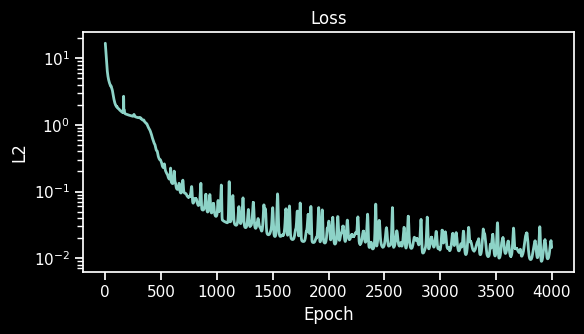

In [8]:
sbplot(losses, x_label='Epoch', y_label='L2', y_scale="log", title='Loss');

==== Reconstruction errors ====
  - Simple Pendulum: 0.83637
  - Inverted Pendulum: 3.21465


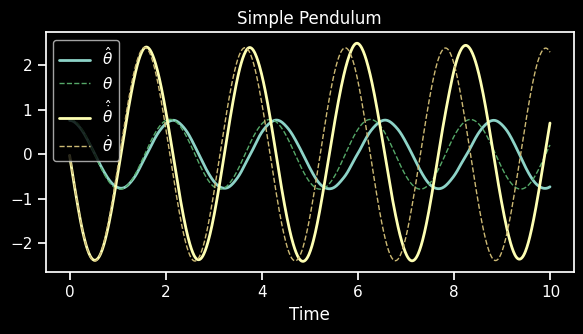

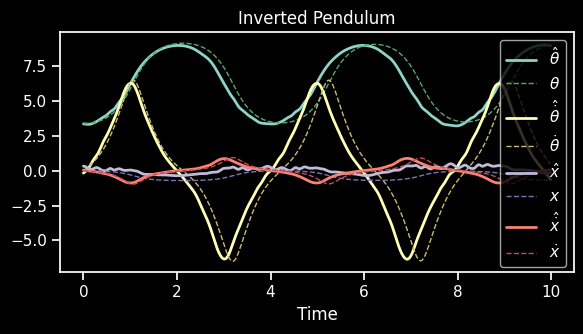

In [9]:
def test_model(model, X1, X2):
    E1, E2, P, D1, D2 = model

    latent1 = E1(X1[0, :-1])
    latent2 = E2(X2[0, :-1])

    latent = jnp.concatenate([latent1, latent2], axis=-1)
    t = X1[:, -1]

    P_params, P_static = eqx.partition(P, eqx.is_array)
    latent_final = integrator(P_params, P_static, latent, t, 1.4e-8, 1.4e-8, jnp.inf, jnp.inf, 2, "checkpointed")

    D1_, D2_ = jax.vmap(D1), jax.vmap(D2)
    X1_hat = D1_(latent_final[:, :latent_size])
    X2_hat = D2_(latent_final[:, latent_size:])

    return X1_hat, X2_hat

X1_hat, X2_hat = test_model(model, X1_raw, X2_raw)

plt_hor = plt_hor*1

times = X1_raw[:plt_hor, -1]

sp_to_plot_ = X1_hat[:plt_hor]
sp_to_plot = X1_raw[:plt_hor]
ax = sbplot(times, sp_to_plot_[:, 0], x_label='Time', label=r'$\hat \theta$', title='Simple Pendulum')
ax = sbplot(times, sp_to_plot[:, 0], "g--", lw=1, x_label='Time', label=r'$\theta$', title='Simple Pendulum',ax=ax)

ax = sbplot(times, sp_to_plot_[:, 1], x_label='Time', label=r'$\hat \dot \theta$', ax=ax)
ax = sbplot(times, sp_to_plot[:, 1], "y--", lw=1, x_label='Time', label=r'$\dot \theta$', ax=ax)

ip_to_plot_ = X2_hat[:plt_hor]
ip_to_plot = X2_raw[:plt_hor]
ax = sbplot(times, ip_to_plot_[:, 2], x_label='Time', label=r'$\hat \theta$', title='Inverted Pendulum')
ax = sbplot(times, ip_to_plot[:, 2], "g--", lw=1, x_label='Time', label=r'$\theta$', title='Inverted Pendulum', ax=ax)

ax = sbplot(times, ip_to_plot_[:, 3], x_label='Time', label=r'$\hat \dot \theta$', ax=ax)
ax = sbplot(times, ip_to_plot[:, 3], "y--", lw=1, x_label='Time', label=r'$\dot \theta$', ax=ax)

ax = sbplot(times, ip_to_plot_[:, 0], x_label='Time', label=r'$\hat x$', ax=ax)
ax = sbplot(times, ip_to_plot[:, 0], "m--", lw=1, x_label='Time', label=r'$x$', ax=ax)

ax = sbplot(times, ip_to_plot_[:, 1], x_label='Time', label=r'$\hat \dot x$', ax=ax)
ax = sbplot(times, ip_to_plot[:, 1], "r--", lw=1, x_label='Time', label=r'$\dot x$', ax=ax)

RE1 = l2_norm(X1_raw[..., :-1], X1_hat)
RE2 = l2_norm(X2_raw[..., :-1], X2_hat)
print("==== Reconstruction errors ====")
print(f"  - Simple Pendulum: {RE1:.5f}")
print(f"  - Inverted Pendulum: {RE2:.5f}")

In [10]:
eqx.tree_serialise_leaves("data/model_002.eqx", model)
# model = eqx.tree_deserialise_leaves("data/model001.eqx", model)

 # Reconstruction errors
 - Only latent1 used:
 - Only latent2 used:
 # Conclusion

 We have one encoder, multiple processors, one decoder. The processors work as follows:

 $$  \frac{dY}{dt} = \alpha_1 F_{\theta_1} + \alpha_2 F_{\theta_2} + ...+ \alpha_K F_{\theta_K} $$